# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import os
import shutil

import sys
import scipy.io
import scipy.misc


import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

import pprint

==============================================================================================================

# Transfer Learning using VGG-19 

In [ ]:
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='PreTrained-Model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg.layers)

[   <keras.engine.input_layer.InputLayer object at 0x7fa375ac23d0>,


==============================================================================================================

# Importing Content Image

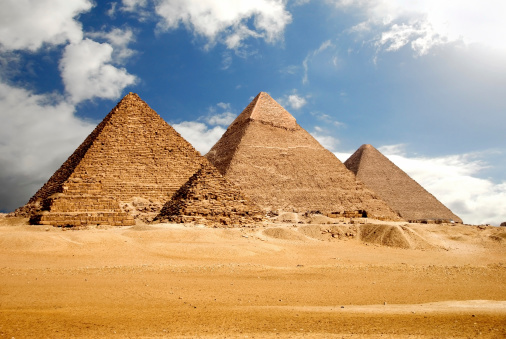

In [ ]:
content_image = Image.open("images/content2.jpg")
content_image

==============================================================================================================

# Computing Cost function of Content image 

In [ ]:

def compute_content_cost(content_output, generated_output):
 
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C]) 
    
   
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

In [ ]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))


J_content = tf.Tensor(7.056877, shape=(), dtype=float32)


==============================================================================================================

# Importing Style Image

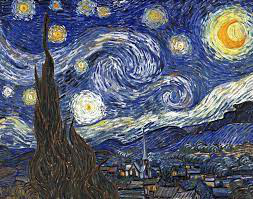

In [ ]:
example = Image.open("images/style2.jpg")
example

==============================================================================================================

# Making Cost function of Style image

In [ ]:
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [ ]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))


GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


In [ ]:

def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
   
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
   
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
    
    
    return J_style_layer

In [ ]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))


J_style_layer = tf.Tensor(14.017805, shape=(), dtype=float32)


==============================================================================================================

# Model

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0     

In [ ]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 1.0),
    ('block2_conv1', 0.8),
    ('block3_conv1', 0.7),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.1)]

==============================================================================================================

In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
  
    J_style = 0

  
    a_S = style_image_output[1:]


    a_G = generated_image_output[1:]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        
        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha * J_content + beta * J_style
    

    return J

In [ ]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

J = tf.Tensor(32.9832, shape=(), dtype=float32)


==============================================================================================================

# Loading and Processing the Images

(1, 400, 400, 3)


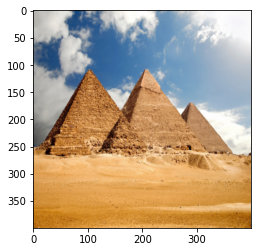

In [ ]:
content_image = np.array(Image.open("images/content2.jpg").resize((img_size, img_size)))

content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
plt.imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


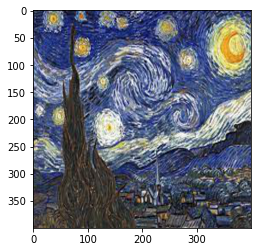

In [ ]:
style_image =  np.array(Image.open("images/style2.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
plt.imshow(style_image[0])
plt.show()

==============================================================================================================

# Initializing Generated Image

(1, 400, 400, 3)


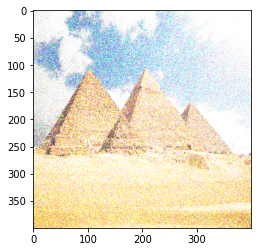

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
plt.imshow(generated_image.numpy()[0])
plt.show()

==============================================================================================================

# Loading the Model

In [ ]:
def get_layer_outputs(vgg, layer_names):
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  
style_targets = vgg_model_outputs(style_image)     

==============================================================================================================

# Computing the total cost

In [ ]:

preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)


a_G = vgg_model_outputs(generated_image)

J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.0073670167, shape=(), dtype=float32)


In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)


J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(5204.4033, shape=(), dtype=float32)


In [ ]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return Image.fromarray(tensor)

==============================================================================================================

# Training the Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

def train_step(generated_image, alpha = 10, beta = 40):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
    
        J_style = compute_style_cost(a_S, a_G)

        J_content = compute_content_cost(a_C, a_G)
       
        J = total_cost(J_content, J_style,alpha = alpha, beta = beta)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    
    return J

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"

J2 = train_step(generated_image)
print(J2)

tf.Tensor(97259.52, shape=(), dtype=float32)
tf.Tensor(45901.207, shape=(), dtype=float32)


In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

epochs = 2501
for i in tf.range(epochs):
    train_step(generated_image,alpha = 100, beta = 10**2)
    if i % 100 == 0:
        print(f"Epoch {i} ")
    if i % 100 == 0:
        image = tensor_to_image(generated_image)
        #plt.imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show()   

Epoch 0 
Epoch 100 
Epoch 200 
Epoch 300 
Epoch 400 
Epoch 500 
Epoch 600 
Epoch 700 
Epoch 800 
Epoch 900 
Epoch 1000 
Epoch 1100 
Epoch 1200 
Epoch 1300 
Epoch 1400 
Epoch 1500 
Epoch 1600 
Epoch 1700 
Epoch 1800 
Epoch 1900 
Epoch 2000 
Epoch 2100 
Epoch 2200 
Epoch 2300 
Epoch 2400 
Epoch 2500 


==============================================================================================================

# Showing Results

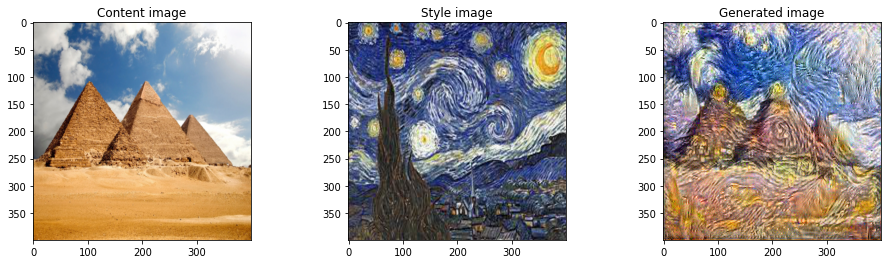

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
plt.imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
plt.imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

==============================================================================================================